In [50]:
pip install pymannkendall

Note: you may need to restart the kernel to use updated packages.


In [51]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array
import pymannkendall as mk

Mann Kendall

In [59]:
df = pandas.read_csv('Boulder_spei.csv')
new_data = df['spei']
result = mk.original_test(new_data)
trend, h, p, z, Tau, s, var_s, slope = mk.original_test(new_data)
print(result)
print("\n")
print("**********THE TREND IS*******\n")
print(trend)
print("\n")


Mann_Kendall_Test(trend='decreasing', h=True, p=4.440892098500626e-16, z=-8.150828771835675, Tau=-0.14645458271589368, s=-139353.0, var_s=292296000.3333333, slope=-0.0005757403214404391)


**********THE TREND IS*******

decreasing




LSTM model

t+1 RMSE: 1.383584
t+2 RMSE: 1.347997
t+3 RMSE: 1.357088
t+4 RMSE: 1.352711
t+5 RMSE: 1.363727
t+6 RMSE: 1.351171
t+7 RMSE: 1.365519
t+8 RMSE: 1.369359
t+9 RMSE: 1.361115
t+10 RMSE: 1.353438
t+11 RMSE: 1.376560
t+12 RMSE: 1.365765


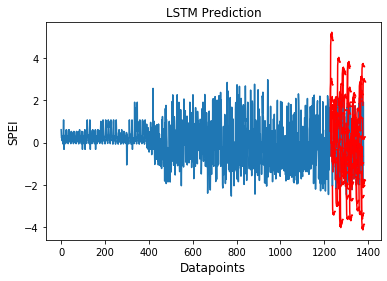

In [44]:
def date_converter(x):
    return datetime.strptime(x, '%Y-%m-%d')

def labels(data, input_dim=1, output_dim=1, dropnan=True):
    n_dim = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    for i in range(input_dim, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_dim)]
    for i in range(0, output_dim):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_dim)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_dim)]
    data_final = concat(cols, axis=1)
    data_final.columns = names
    if dropnan:
        data_final.dropna(inplace=True)
    return data_final

def delta(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

def data_split(series, n_test, n_lag, n_seq):
    raw_values = series.values
    diff_series = delta(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    supervised = labels(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    train, test, = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test

def lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

def forecast_lstm(model, X, n_batch):
    X = X.reshape(1, 1, len(X))
    forecast = model.predict(X, batch_size=n_batch)
    return [x for x in forecast[0, :]]

def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        forecast = forecast_lstm(model, X, n_batch)
        forecasts.append(forecast)
    return forecasts

def inverse_difference(last_ob, forecast):
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        inverted.append(inv_diff)
    return inverted

def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))

def plot_forecasts(series, forecasts, n_test):
    pyplot.plot(series.values,label = "Actual data")
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        pyplot.plot(xaxis, yaxis, color='red',label = "Forecasted data")
    pyplot.xlabel("Datapoints",fontsize=12)
    pyplot.ylabel("SPEI",fontsize=12)
    pyplot.title("LSTM Prediction",fontsize=12)
    pyplot.show()

series = read_csv('Boulder_spei.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=date_converter,usecols=['time','spei'])
n_lag = 1
n_seq = 12
n_test = 150
n_epochs = 50
n_batch = 1
n_neurons = 1
scaler, train, test = data_split(series, n_test, n_lag, n_seq)
model = lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)
evaluate_forecasts(actual, forecasts, n_lag, n_seq)
plot_forecasts(series, forecasts, n_test+2)

In [45]:
dates=series.index.values
# dates
X = series.values
test_indices = dates[-n_test:]

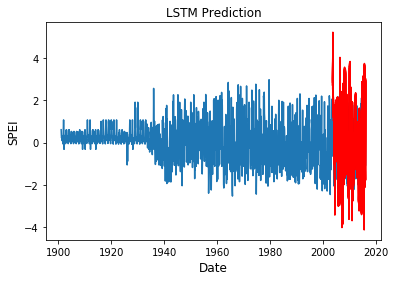

In [46]:
# pyplot.figure(figsize=(15,10))
pyplot.plot(dates,X,label="Actual data")
pyplot.plot(test_indices,forecasts,label="Predicted data",color='red')
pyplot.xlabel("Date",fontsize=12)
pyplot.ylabel("SPEI",fontsize=12)
pyplot.title("LSTM Prediction",fontsize=12)
# pyplot.legend()
pyplot.savefig("LSTM.png")